In [1]:
#!/usr/bin/env python
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd, random, numpy as np, time, math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from FastChemTokenizerHF import FastChemTokenizerSelfies
from scmt import SchemaAugmentedSOMT, SOMTConfig
from torch.cuda.amp import autocast, GradScaler

# ====================================================
# 0. Setup
# ====================================================
seed = 2025
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using {device}")

# ====================================================
# 1. Dataset + Tokenization (with subsampling)
# ====================================================
# ====================================================
# 1. Dataset + Tokenization (with 90/10 train/test split)
# ====================================================
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=64):
        self.texts = texts
        self.tokenizer = tokenizer
        self.seq_len = seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        toks = self.tokenizer.encode(self.texts[idx])
        toks = toks[: self.seq_len]
        if len(toks) < self.seq_len:
            toks += [self.tokenizer.pad_token_id] * (self.seq_len - len(toks))
        x = torch.tensor(toks, dtype=torch.long)
        y = torch.roll(x, shifts=-1, dims=0)
        return x, y

# Load full dataset
tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")
df = pd.read_csv("./data/test.csv")
texts = df["SELFIES"].astype(str).tolist() if "SELFIES" in df.columns else df.iloc[:, 0].astype(str).tolist()

# Shuffle and split
random.seed(seed)  # for reproducibility
indices = list(range(len(texts)))
random.shuffle(indices)
split_idx = int(0.1 * len(indices))
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

train_texts = [texts[i] for i in train_indices]
test_texts = [texts[i] for i in test_indices]

seq_len = 90
train_ds = TextDataset(train_texts, tokenizer, seq_len)
test_ds = TextDataset(test_texts, tokenizer, seq_len)

print(f"📚 Train: {len(train_ds)} samples | Test: {len(test_ds)} samples")
print(f"   Total: {len(train_ds) + len(test_ds)} | Vocab size: {tokenizer.vocab_size}")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)
vocab_size = tokenizer.vocab_size
print(f"📚 Dataset: {len(train_ds)} samples | Vocab size: {vocab_size}")

# ====================================================
# 2. Model
# ====================================================
config = SOMTConfig(vocab_size=vocab_size, d_model=256, nhead=8, num_layers=4, max_len=256, mem_size=128, num_schemas=32)
model = SchemaAugmentedSOMT(
    config.vocab_size,
    d_model=config.d_model,
    nhead=config.nhead,
    num_layers=config.num_layers,
    max_len=config.max_len,
    mem_size=config.mem_size,
    num_schemas=config.num_schemas
).to(device)

# ====================================================
# 3. Train
# ====================================================
def evaluate(model, loader, criterion):
    model.eval(); total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, *_ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader), np.exp(total_loss / len(loader))

def train_model(epochs=1):
    opt = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9,0.95), weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    scaler = GradScaler()

    history = {"train_loss": [], "eval_loss": [], "ppl": []}
    metrics_log = {
        "budget": [], "schema_util": [], "lm_loss": [], "schema_loss": [],
        "entropy_reg": [], "importance_l2": [], "schema_ema_sum": []  # NEW
    }

    first_batch_done = False
    for ep in range(epochs):
        model.train(); total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", leave=False)
        for batch_idx, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)

            with autocast(dtype=torch.float16):
                logits, _, _, _, aux = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                total_aux = aux["importance_entropy"] + aux["importance_l2"] + aux["schema_utility"]
                total_loss_combined = loss + total_aux

            scaler.scale(total_loss_combined).backward()
            scaler.step(opt)
            scaler.update()

            if not first_batch_done:
                print("\n🔍 Aux Loss Sanity Check:")
                print(f"  Entropy reg: {aux['importance_entropy'].item():.6f}")
                print(f"  L2 importance: {aux['importance_l2'].item():.6f}")
                print(f"  Schema utility: {aux['schema_utility'].item():.6f}")
                first_batch_done = True

            with torch.no_grad():
                metrics_log["lm_loss"].append(loss.item())
                metrics_log["schema_loss"].append(aux["schema_utility"].item())
                metrics_log["entropy_reg"].append(aux["importance_entropy"].item())
                metrics_log["importance_l2"].append(aux["importance_l2"].item())

                mem_ts = aux["memory_timestamps"]
                used_slots = (mem_ts != 1e9).sum(dim=1).float().mean().item()
                metrics_log["budget"].append(used_slots / model.mem_size)

                metrics_log["schema_util"].append(aux["schema_utility"].item())
                # NEW: Log EMA schema usage sum (SSRU tracks this)
                metrics_log["schema_ema_sum"].append(model.schema_utility_sum.mean().item())

            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        tr_loss = total_loss / len(train_loader)
        ev_loss, ppl = evaluate(model, test_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["eval_loss"].append(ev_loss)
        history["ppl"].append(ppl)
        print(f"Epoch {ep+1}: train {tr_loss:.3f} | eval {ev_loss:.3f} | ppl {ppl:.2f}")

    return model, history, metrics_log

# ====================================================
# 4. Schema Inspector (polished)
# ====================================================
def inspect_schemas(model, tokenizer, top_k=8):
    model.eval()
    with torch.no_grad():
        schema_logits = model.lm_head(model.schema_vals)
        probs = F.softmax(schema_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, top_k, dim=-1)
        for s in range(model.num_schemas):
            tokens = [tokenizer.decode([tid.item()]) for tid in top_ids[s]]
            scores = top_probs[s].tolist()
            # Only show tokens with prob > 0.001 for readability
            filtered = [(tok, score) for tok, score in zip(tokens, scores) if score > 0.001]
            if not filtered:
                filtered = [(tokens[0], scores[0])]  # fallback
            line = " | ".join([f"{tok} ({score:.3f})" for tok, score in filtered[:5]])  # top 5
            print(f"Schema {s:2d}: {line}")

# ====================================================
# 5. Generation (unchanged — already correct)
# ====================================================
@torch.no_grad()
def generate_text(model, tokenizer, prompt="", max_len=80, temperature=1.2):
    model.eval()
    device = next(model.parameters()).device
    if prompt == "":
        start_id = tokenizer.bos_token_id or tokenizer.eos_token_id or 0
        input_ids = torch.tensor([[start_id]], dtype=torch.long, device=device)
    else:
        input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    output = model.generate(
        tokenizer=tokenizer,
        input_ids=input_ids,
        max_length=max_len,
        temperature=temperature,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )
    return output if isinstance(output, str) else tokenizer.decode(output, skip_special_tokens=True)

# ====================================================
# 6. Run
# ====================================================
if __name__ == "__main__":
    model, hist, metrics = train_model(epochs=1)

    save_dir = "./checkpoints/somt_w_test"
    model.save_pretrained(save_dir)
    model_loaded = SchemaAugmentedSOMT.from_pretrained(save_dir).to(device)
    print("✅ Model reloaded successfully.")

    print("\n🧪 Generation Samples:")
    for i in range(3):
        print(f"Sample {i+1}: {generate_text(model_loaded, tokenizer)}")

    print("\n🔍 Schema Tokens (Post-Training):")
    inspect_schemas(model_loaded, tokenizer)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1); plt.plot(metrics["budget"]); plt.title("Memory Budget"); plt.ylim(0,1)
    plt.subplot(2, 2, 2); plt.plot(metrics["schema_util"]); plt.title("Schema Utility")
    plt.subplot(2, 2, 3); plt.plot(metrics["lm_loss"]); plt.title("LM Loss")
    plt.subplot(2, 2, 4); plt.plot(metrics["entropy_reg"], label="Entropy"); plt.plot(metrics["importance_l2"], label="L2"); plt.legend(); plt.title("Aux Losses")
    plt.tight_layout()
    plt.savefig("scmt_metrics.png", dpi=150)

    avg_budget = np.mean(metrics["budget"])
    print(f"\n✅ Memory Budget Avg: {avg_budget:.3f} (expected: 0.2–0.9)")
    if 0.2 <= avg_budget <= 0.9:
        print("✅ PASSED: Adaptive memory gating confirmed.")
    else:
        print("⚠️  WARNING: Budget out of range.")

    # NEW: Check schema EMA stabilization
    final_ema = metrics["schema_ema_sum"][-1]
    print(f"📊 Final Schema EMA Mean: {final_ema:.4f} (should rise then stabilize)")

🚀 Using cuda
✅ Special tokens bound: 0 1 2 3 4
📚 Train: 2414 samples | Test: 21733 samples
   Total: 24147 | Vocab size: 793
📚 Dataset: 2414 samples | Vocab size: 793


C:\Users\mori\AppData\Local\Temp\ipykernel_13224\2476309687.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/1:   0%|          | 0/302 [00:00<?, ?it/s]

C:\Users\mori\AppData\Local\Temp\ipykernel_13224\2476309687.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):



🔍 Aux Loss Sanity Check:
  Entropy reg: 0.179800
  L2 importance: 0.232333
  Schema utility: 0.004941


KeyboardInterrupt: 

In [2]:
@torch.no_grad()
def generate_text(model, tokenizer, prompt="", max_len=80, temperature=1.8):
    model.eval()
    device = next(model.parameters()).device

    if prompt == "":
        start_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
        input_ids = torch.tensor([[start_id]], dtype=torch.long, device=device)
    else:
        input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    # Let model.generate handle decoding if tokenizer is provided
    output = model.generate(
        tokenizer=tokenizer,
        input_ids=input_ids,
        max_length=max_len,
        temperature=temperature,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    # model.generate returns a STRING if tokenizer is passed, else a list of IDs
    if isinstance(output, list):
        return tokenizer.decode(output, skip_special_tokens=True)
    else:
        return output  # already a string
print("🧪 Generation Test (Reloaded):")
for i in range(2):
    print(f"--- Sample {i+1} ---")
    print(generate_text(model, tokenizer, prompt="", max_len=60))


🧪 Generation Test (Reloaded):
--- Sample 1 ---
[C] [C] [=C] [C] [Branch2] [Branch1] [C] [C] [C] [C] [Ring1] [C] [=C] [C] [=C] [C] [Ring2] [O] [Ring2] [=Branch1] [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] [Branch2] [C] [C] [C] [=O] [N] [C] [C] [C] [=C] [C] [C] [Branch1] [C] [C] [C] [C] [Ring1] [#Branch1] [O] [=C] [N] [Ring1] [O] [C] [C]
--- Sample 2 ---
[C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] [O] [Branch1] [=N] [C] [=C] [#Branch1] [N] [C] [C] [C] [=C] [O] [C] [=C] [C] [=C] [Branch1] [C] [C] [C] [C] [C] [C] [O] [C] [=C] [Ring1]


In [4]:
import selfies as sf

tokens = "[C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] [O] [Branch1] [=N] [C] [=C] [#Branch1] [N] [C] [C] [C] [=C] [O] [C] [=C] [C] [=C] [Branch1] [C] [C] [C] [C] [C] [C] [O] [C] [=C] [Ring1]"
tokens = tokens.replace(" ", "")
print(sf.decoder(tokens))

COC=CC=CNC=C(CCC=COC=CC=CC)CCCCOC#C


In [5]:
@torch.no_grad()
def visualize_schemas_correct(model, tokenizer, top_k=8):
    model.eval()
    device = next(model.parameters()).device

    # Get raw token embeddings
    embed_matrix = model.embed.weight.data  # (V, D)

    # Project them into KEY space (same as schema_keys)
    projected_tokens = model.key_proj(embed_matrix)  # (V, D)

    # Normalize both
    schema_norm = F.normalize(model.schema_keys, p=2, dim=-1)  # (S, D)
    token_norm = F.normalize(projected_tokens, p=2, dim=-1)     # (V, D)

    # Compute similarity in KEY space
    sim = torch.mm(schema_norm, token_norm.T)  # (S, V)

    # Decode top tokens
    for i in range(sim.size(0)):
        top_vals, top_ids = torch.topk(sim[i], k=top_k, largest=True)
        tokens = [tokenizer.decode([tid.item()]) for tid in top_ids]
        print(f"Schema {i:2d}: " + " | ".join(f"{t} ({v:.3f})" for t, v in zip(tokens, top_vals)))

In [6]:
visualize_schemas_correct(model, tokenizer, top_k=8)

Schema  0: [O] [=C] [C] [=C] [C] [Branch1] (0.176) | [Cl] [C] [=C] [C] [=C] (0.163) | .[C] (0.163) | 9 (0.159) | [/P+1] (0.157) | [C] [=C] [C] [N] [C] (0.151) | [C] [O] [C] [=C] [C] [=C] [N] [=C] (0.147) | [C] [C] [N] [Branch1] [Ring1] [C] [C] [C] (0.145)
Schema  1: [CH1-1] (0.183) | [Zn+2] (0.182) | [/SeH1] (0.175) | [O] [=C] [Branch1] [O] [C] (0.171) | [O] [=C] [O] [C] [C] [Branch1] (0.170) | [125IH1] (0.166) | [Cl] [C] [=C] [C] [=C] [Branch2] (0.157) | [O] [=C] [C] [=Branch1] [C] [=O] (0.154)
Schema  2: [O] [=C] (0.173) | [C] [O] [C] [=C] [C] [=C] (0.172) | [\O-1] (0.150) | [18F-1] (0.140) | [C] [C@] (0.134) | [=32PH1] (0.133) | [C] [C] [C] [O] [C] (0.130) | [14CH3] (0.129)
Schema  3: [O] [=C] [Branch2] [Ring1] [Ring2] (0.171) | [C] [N] [Branch1] [C] [C] [C] [C] (0.161) | [/N] (0.144) | [C] [O] [C] [=C] [C] [=C] [Branch1] (0.143) | [C] [N] [C] [=C] [Branch2] (0.142) | [\CH1-1] (0.137) | [124I] (0.136) | [O] [C] [=C] [C] [=C] [C] (0.135)
Schema  4: [/C-1] (0.183) | [O] [=C] [Branch1]

🔍 Evaluation Summary
📘 SCMT Loss: 1.7637 ± 0.0106
📗 GPT-2 Loss: 1.8634 ± 0.0173
-
📘 SCMT PPL: 5.83 ± 0.06
📗 GPT-2 PPL: 6.45 ± 0.11
------------------------------------------------------------
Relative Improvement: 5.35% lower loss
Cohen's d Effect Size: 3.62
Paired t-test: t=6.28, p=0.0245


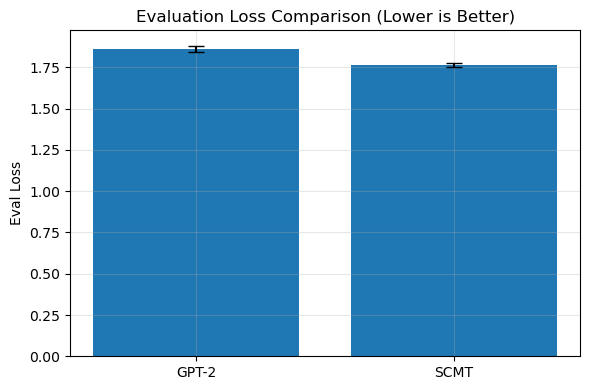

C:\Users\mori\AppData\Local\Temp\ipykernel_10188\3819788365.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gpt2_ppl, somt_ppl], labels=["GPT-2", "SCMT"])


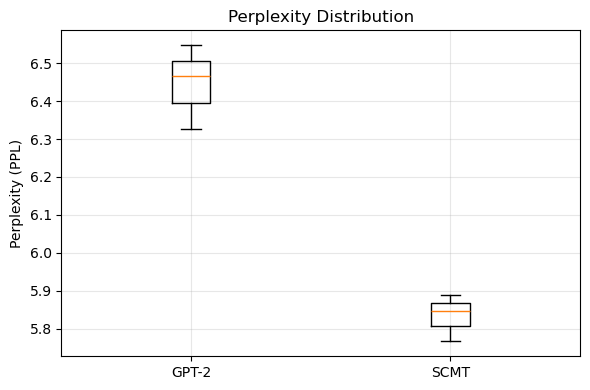

In [1]:
# ====================================================
# 📊 SCMT vs GPT-2 A/B Evaluation Summary
# ====================================================

import json, numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# === Load results ===
with open("mol_ab_results_epoch1.json") as f:
    data = json.load(f)

somt = data["results"]["somt"]
gpt2 = data["results"]["gpt2"]

somt_losses = np.array([r["loss"] for r in somt])
somt_ppl = np.array([r["ppl"] for r in somt])
gpt2_losses = np.array([r["loss"] for r in gpt2])
gpt2_ppl = np.array([r["ppl"] for r in gpt2])

# === Compute stats ===
def summarize(x):
    return np.mean(x), np.std(x, ddof=1)

somt_mean, somt_std = summarize(somt_losses)
gpt2_mean, gpt2_std = summarize(gpt2_losses)

ppl_mean_somt, ppl_std_somt = summarize(somt_ppl)
ppl_mean_gpt2, ppl_std_gpt2 = summarize(gpt2_ppl)

# paired t-test
tstat, pval = stats.ttest_rel(gpt2_losses, somt_losses)

# effect size (Cohen's d for paired samples)
diff = gpt2_losses - somt_losses
cohens_d = diff.mean() / diff.std(ddof=1)

# === Pretty print summary ===
print("🔍 Evaluation Summary")
print("="*60)
print(f"📘 SCMT Loss: {somt_mean:.4f} ± {somt_std:.4f}")
print(f"📗 GPT-2 Loss: {gpt2_mean:.4f} ± {gpt2_std:.4f}")
print("-")
print(f"📘 SCMT PPL: {ppl_mean_somt:.2f} ± {ppl_std_somt:.2f}")
print(f"📗 GPT-2 PPL: {ppl_mean_gpt2:.2f} ± {ppl_std_gpt2:.2f}")
print("-"*60)
print(f"Relative Improvement: {(1 - somt_mean / gpt2_mean) * 100:.2f}% lower loss")
print(f"Cohen's d Effect Size: {cohens_d:.2f}")
print(f"Paired t-test: t={tstat:.2f}, p={pval:.4f}")
print("="*60)

# === Visualization ===
plt.figure(figsize=(6,4))
labels = ["GPT-2", "SCMT"]
means = [gpt2_mean, somt_mean]
errors = [gpt2_std, somt_std]

plt.bar(labels, means, yerr=errors, capsize=6)
plt.title("Evaluation Loss Comparison (Lower is Better)")
plt.ylabel("Eval Loss")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === Optional: Boxplot for PPL ===
plt.figure(figsize=(6,4))
plt.boxplot([gpt2_ppl, somt_ppl], labels=["GPT-2", "SCMT"])
plt.title("Perplexity Distribution")
plt.ylabel("Perplexity (PPL)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



🔍 Schema 0


[10:07:12] unsupported number of radical electrons 4


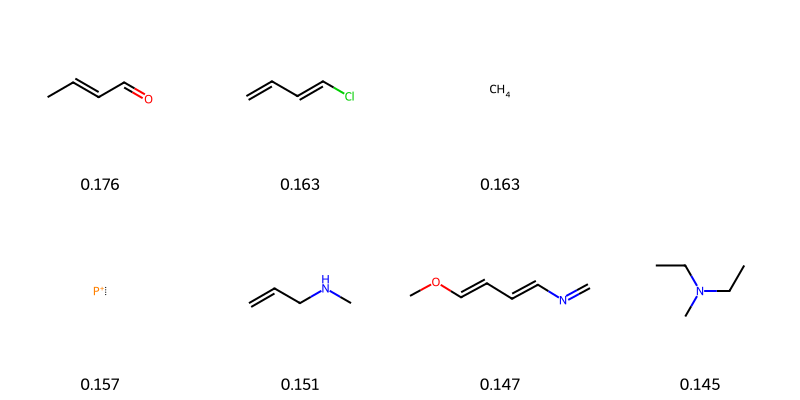


🔍 Schema 1


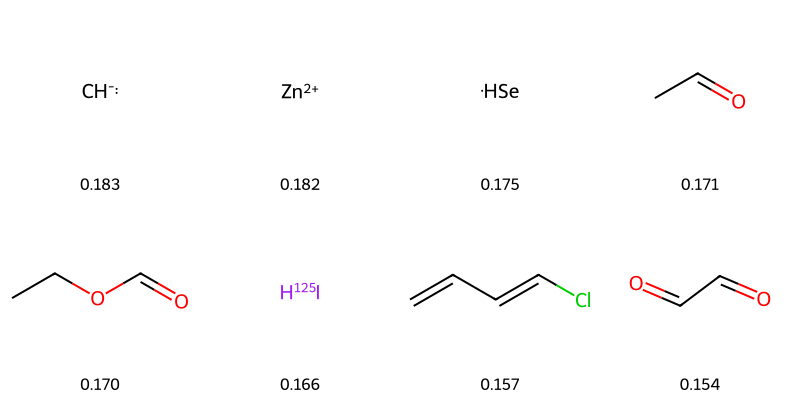


🔍 Schema 2


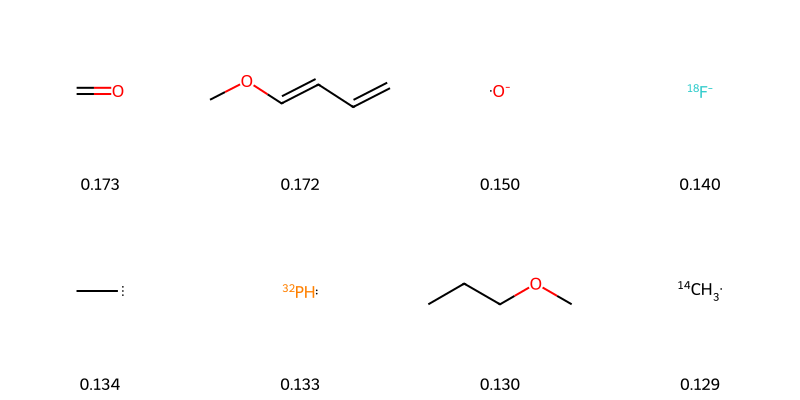


🔍 Schema 3


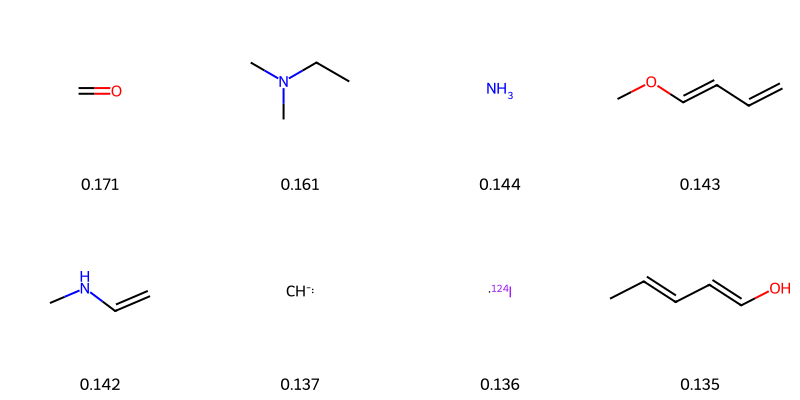


🔍 Schema 4


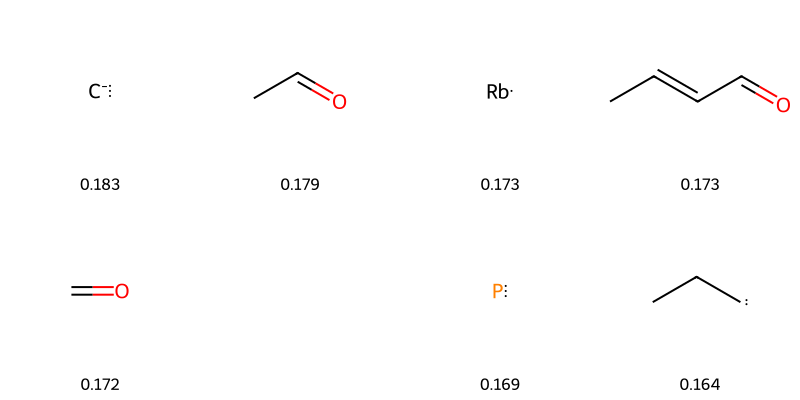


🔍 Schema 5


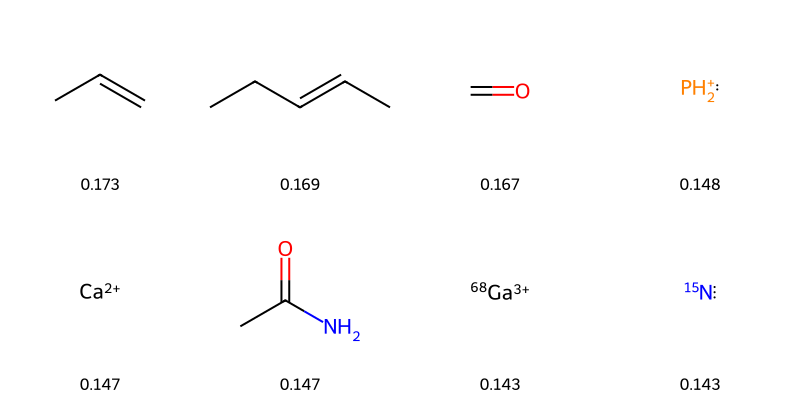


🔍 Schema 6


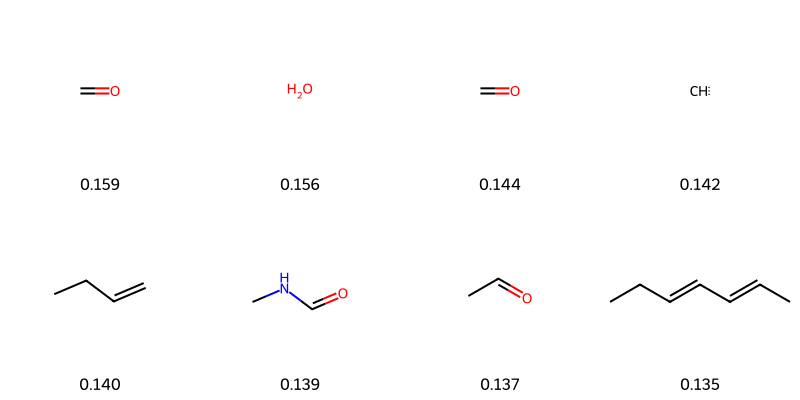


🔍 Schema 7


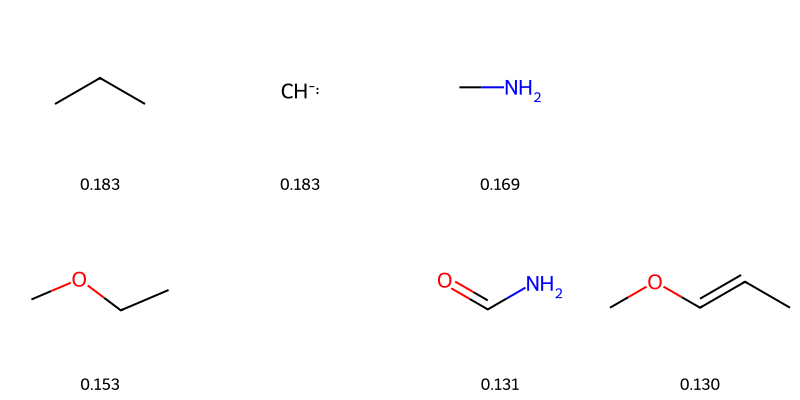


🔍 Schema 8


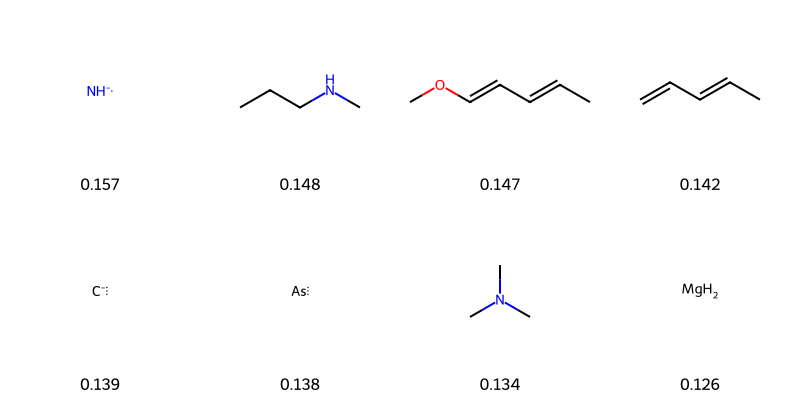


🔍 Schema 9


[10:07:13] WARNING: not removing hydrogen atom without neighbors


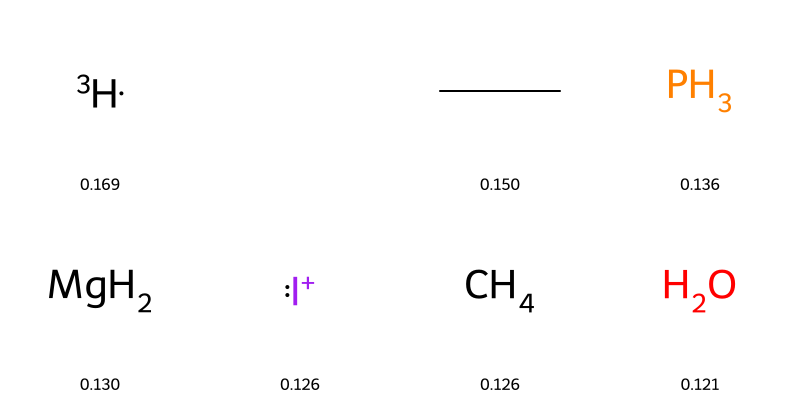


🔍 Schema 10


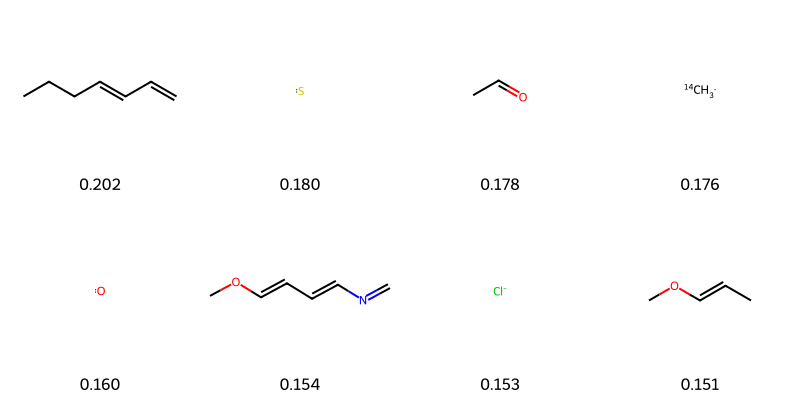


🔍 Schema 11


[10:07:13] unsupported number of radical electrons 4


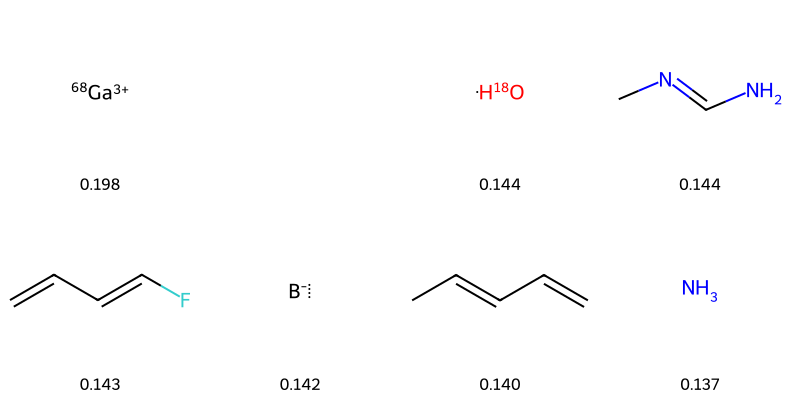


🔍 Schema 12


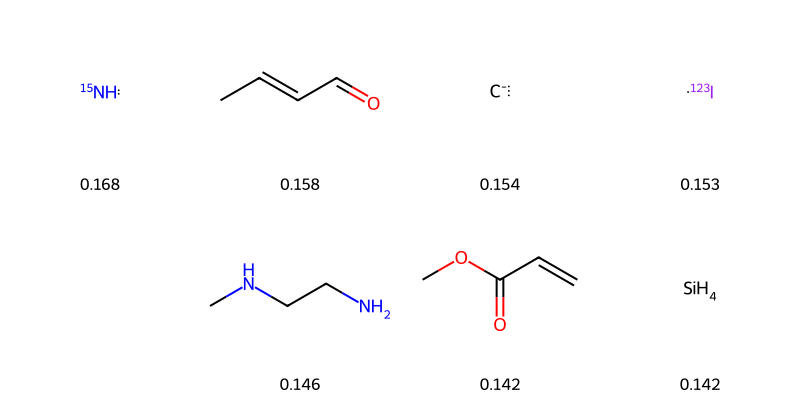


🔍 Schema 13


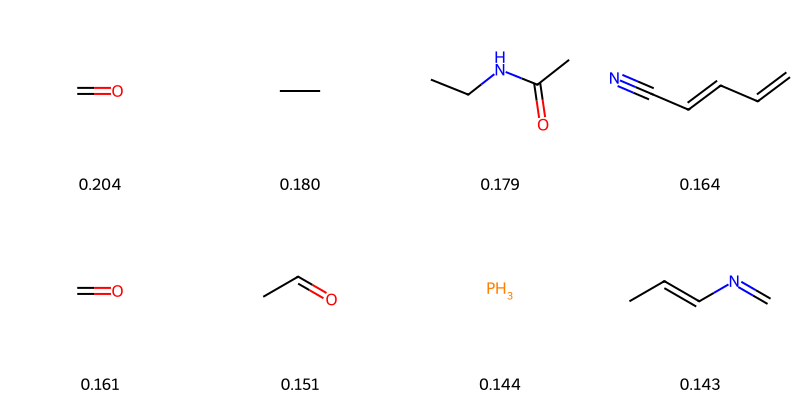


🔍 Schema 14


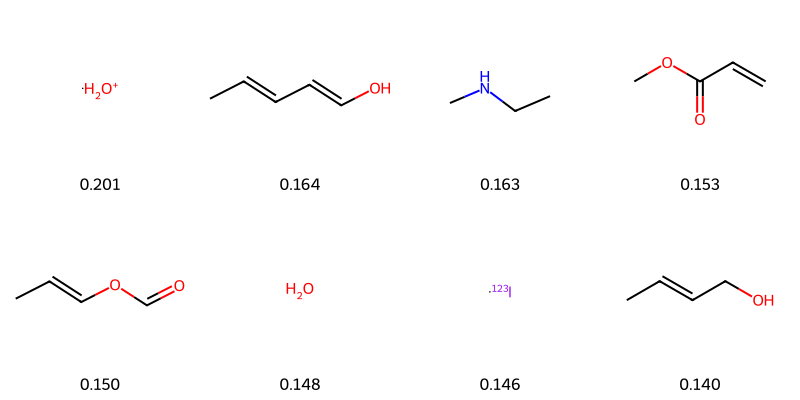


🔍 Schema 15


[10:07:14] WARNING: not removing hydrogen atom without neighbors
[10:07:14] unsupported number of radical electrons 4


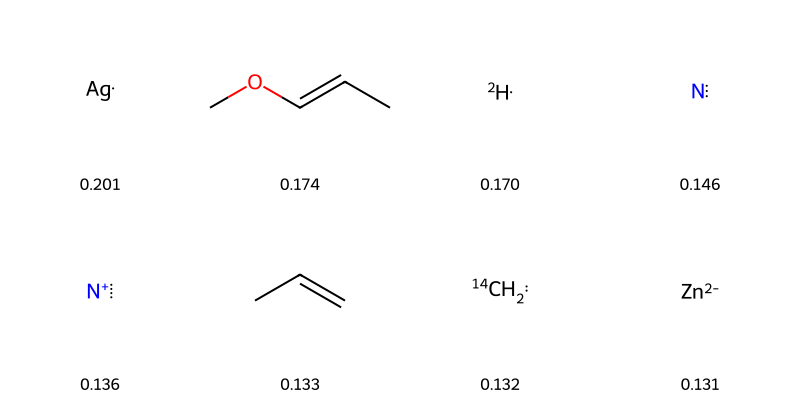


🔍 Schema 16


[10:07:14] unsupported number of radical electrons 4
[10:07:14] unsupported number of radical electrons 4


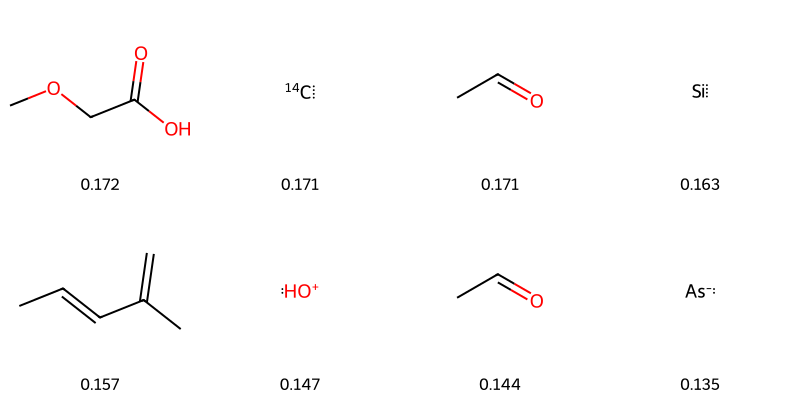


🔍 Schema 17


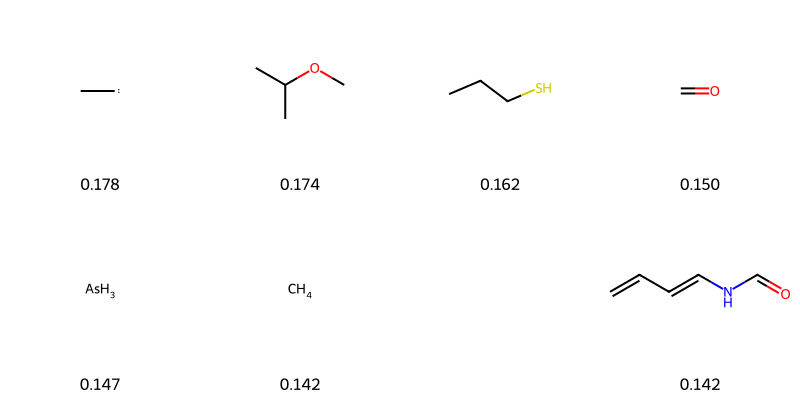


🔍 Schema 18


[10:07:14] unsupported number of radical electrons 4


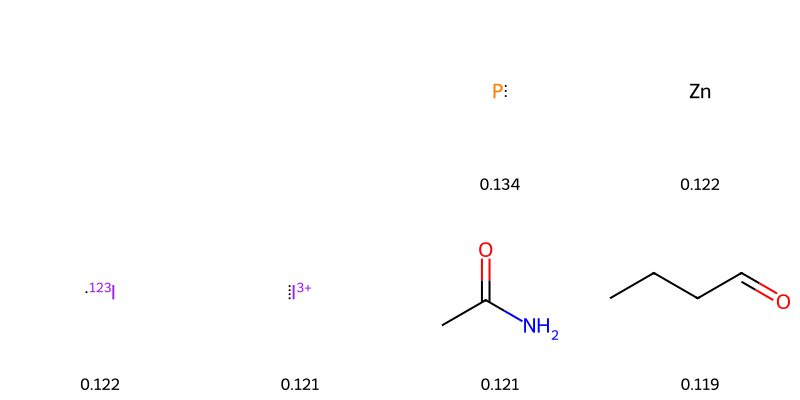


🔍 Schema 19


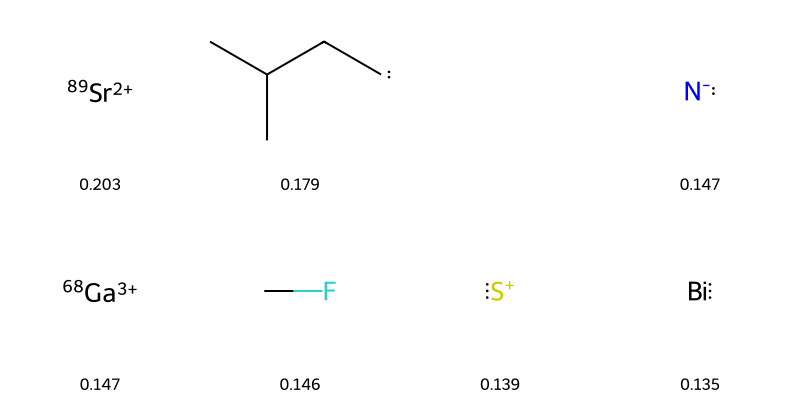


🔍 Schema 20


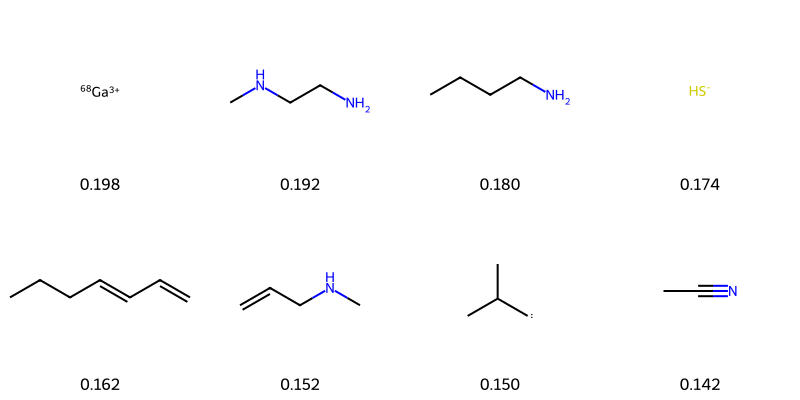


🔍 Schema 21


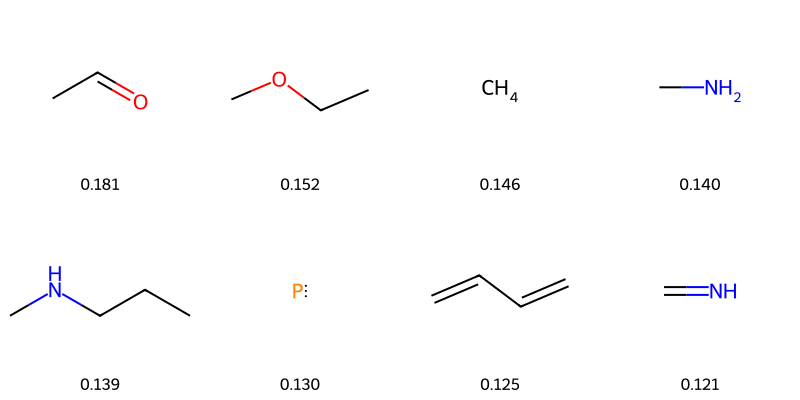


🔍 Schema 22


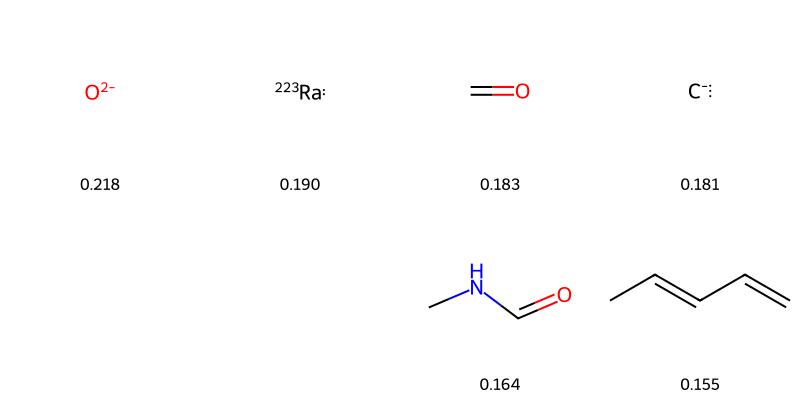


🔍 Schema 23


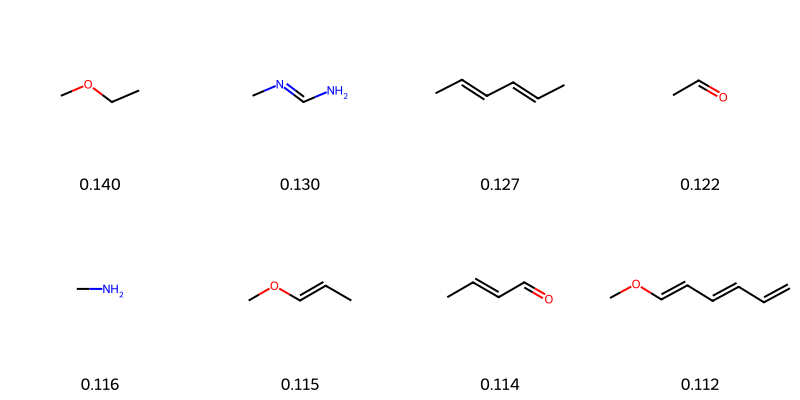


🔍 Schema 24


[10:07:15] unsupported number of radical electrons 4


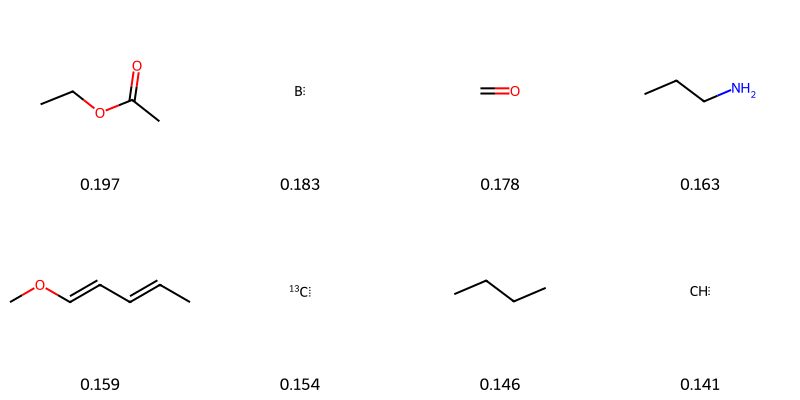


🔍 Schema 25


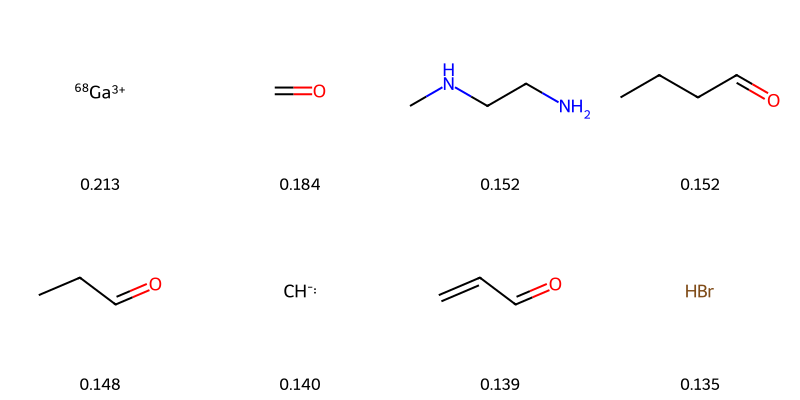


🔍 Schema 26


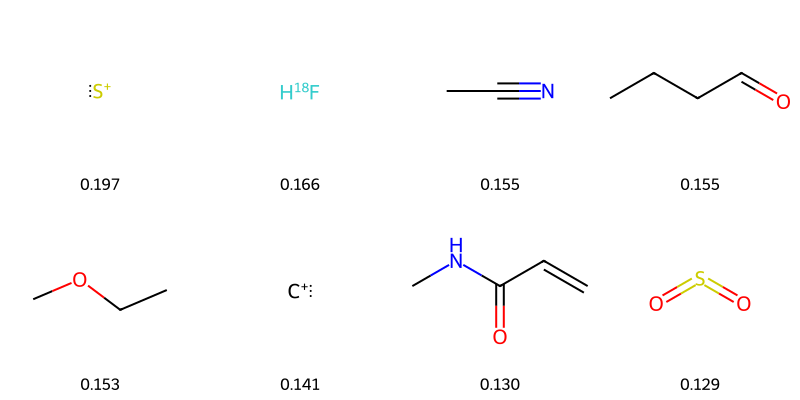


🔍 Schema 27


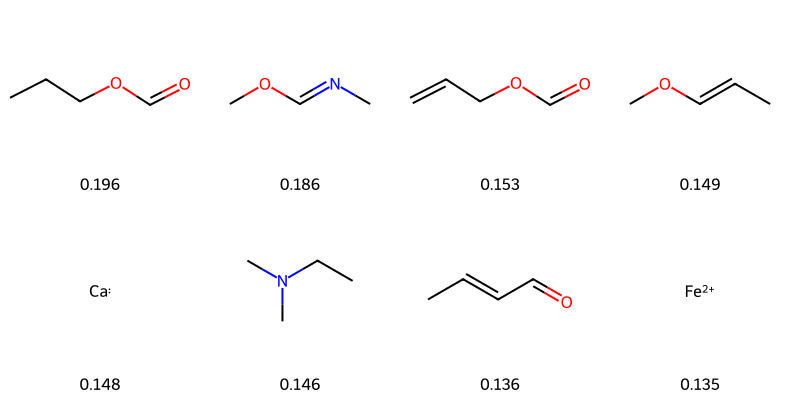


🔍 Schema 28


[10:07:16] unsupported number of radical electrons 4


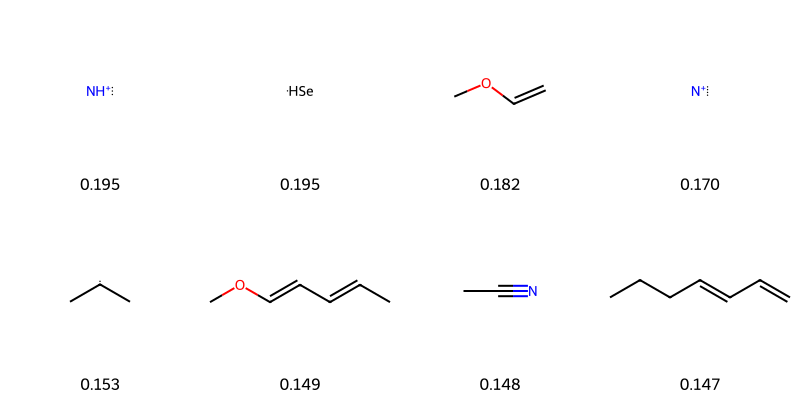


🔍 Schema 29


[10:07:16] unsupported number of radical electrons 4


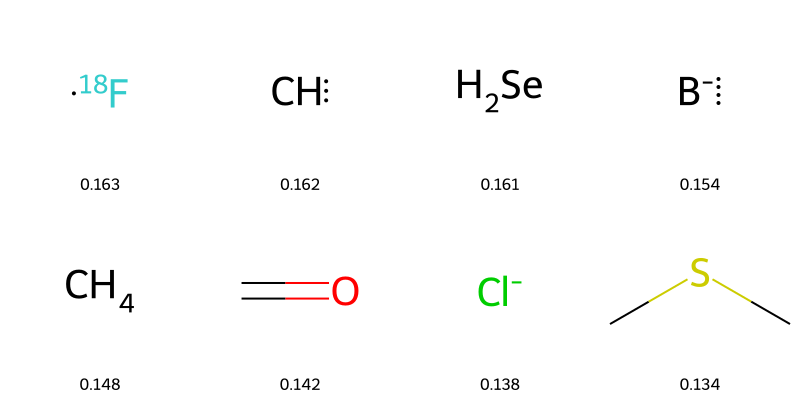


🔍 Schema 30


[10:07:16] unsupported number of radical electrons 4


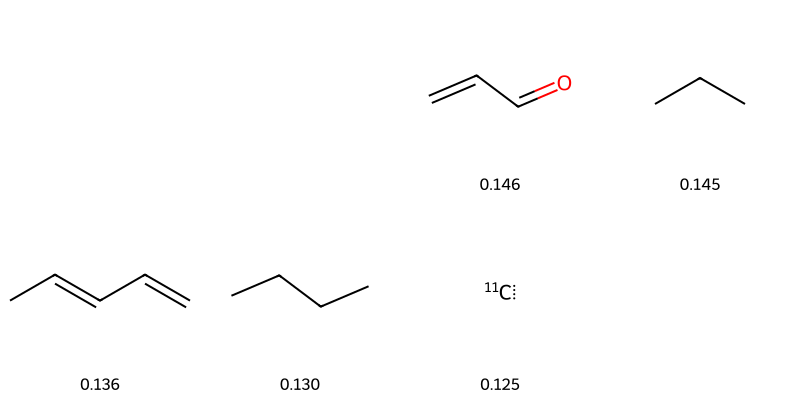


🔍 Schema 31


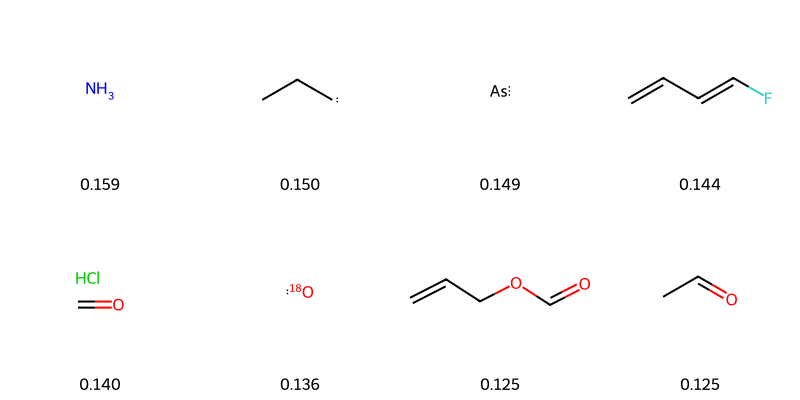

In [7]:
import torch
import torch.nn.functional as F
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")  # suppress RDKit warnings

@torch.no_grad()
def get_schema_top_tokens(model, tokenizer, top_k=8):
    model.eval()
    device = next(model.parameters()).device

    embed_matrix = model.embed.weight.data  # (V, D)
    projected_tokens = model.key_proj(embed_matrix)  # (V, D)

    schema_norm = F.normalize(model.schema_keys, p=2, dim=-1)  # (S, D)
    token_norm = F.normalize(projected_tokens, p=2, dim=-1)     # (V, D)

    sim = torch.mm(schema_norm, token_norm.T)  # (S, V)

    results = []
    for i in range(sim.size(0)):
        top_vals, top_ids = torch.topk(sim[i], k=top_k, largest=True)
        tokens_list = []
        for tid, val in zip(top_ids, top_vals):
            token_str = tokenizer.decode([tid.item()])
            tokens_list.append((token_str, val.item()))
        results.append(tokens_list)
    return results

def render_schema_molecules(schema_results, max_mols_per_schema=8):
    for schema_idx, token_entries in enumerate(schema_results):
        print(f"\n🔍 Schema {schema_idx}")
        mols = []
        labels = []

        for token_str, similarity in token_entries[:max_mols_per_schema]:
            # Clean token string: remove spaces, ensure valid SELFIES
            selfies_str = token_str.replace(" ", "")
            
            try:
                # Decode SELFIES → SMILES
                smiles = sf.decoder(selfies_str)
                
                # Convert SMILES → RDKit Mol
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    raise ValueError("Invalid SMILES")
                
                mols.append(mol)
                labels.append(f"{similarity:.3f}")
                
            except Exception as e:
                # If decoding fails, show placeholder
                print(f"⚠️  Failed to decode: '{token_str}' → {e}")
                # Optionally append a dummy molecule or skip
                continue

        if mols:
            # Render grid
            img = Draw.MolsToGridImage(
                mols,
                molsPerRow=min(len(mols), 4),
                subImgSize=(200, 200),
                legends=labels,
                useSVG=False  # set True if you prefer SVG
            )
            display(img)
        else:
            print("❌ No valid molecules to display for this schema.")

schema_results = get_schema_top_tokens(model, tokenizer, top_k=8)
render_schema_molecules(schema_results)